# Interactive segmentation with hierarchies

This notebook demonstrates the use of hierarchies of partitions for interactive image segmentation.

The whole process mainly relies on the function `binary_labelisation_from_markers` which propagates clues given in the form of scribles by the user through the hierarchy in order to produce a complete binary segmentation of the image.

More precisely, the user provides an "object" and a "background" marker and the algorithm will construct the union the every regions of the hierarchy that intersect the object marker but does not touch the background marker.

**Warning: This notebook requires ``%matplotlib notebook`` and won't work in evironment that doesn't support it (eg. Google Colab)**

As usual we start by some import and magic:

In [1]:
%%capture
!pip install higra

In [2]:
import numpy as np
import imageio
%matplotlib notebook
import matplotlib.pyplot as plt
from skimage.transform import resize
import cv2
import higra as hg

try:
    from utils import * # imshow, locate_resource, get_sed_model_file
except: # we are probably running from the cloud, try to fetch utils functions from URL
    import urllib.request as request; exec(request.urlopen('https://github.com/higra/Higra-Notebooks/raw/master/utils.py').read(), globals())

from skimage.io import imread

In [3]:
import os
import sys
import h5py
from pathlib import Path

sys.path.append('../')
from source.computation_support import *
from source.myGaborFunctions import *
from source.color_transformations import *
from source.plot_save_figures import *
from source.graph_operations import *
from source.chameleon import *

from source.color_seg_methods import *
# %matplotlib qt

Image loading and gradient computation:

In [4]:
# Read and show input image
inDir = '../../data/images/500images/test/'
list_imgs = os.listdir(inDir)
img_file = list_imgs[60]

image = io.imread(inDir + img_file)
size = image.shape


In [7]:
size[:2]

(481, 321)

In [8]:
# # we reduce the image size a bit to fit on small screens...
image = resize(image, (int(size[0]*0.65), int(size[1]*0.65)), mode="reflect")
# print(image.dtype)
image = image.astype(np.float32) 

# gradient computation
# detector = cv2.ximgproc.createStructuredEdgeDetection(get_sed_model_file())
# gradient_image = detector.detectEdges(image)
gradient_image = io.imread(img_file.split('.')[0] + '.jpg')
gradient_image = resize(gradient_image, (int(size[0]*0.65), int(size[1]*0.65)), mode="reflect")
# add alpha channel to image for visualisation
image_alpha = np.pad(image, ((0,0),(0,0),(0,1)), mode='constant', constant_values=1)

size = image.shape[:2]


In [9]:
print(size)

(312, 208)


<IPython.core.display.Javascript object>


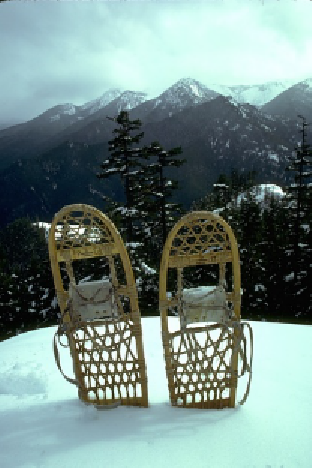

<IPython.core.display.Javascript object>


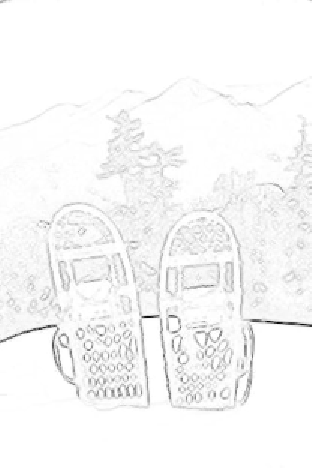

(<Figure size 312x468 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fab8850b090>)

In [6]:
imshow(image)
imshow(255-gradient_image, cmap='gray')

Hierarchy construction

In [7]:
graph = hg.get_4_adjacency_graph(size)
edge_weights = hg.weight_graph(graph, gradient_image, hg.WeightFunction.mean)
tree, altitudes = hg.watershed_hierarchy_by_volume(graph, edge_weights)

In [8]:
edge_weights.shape

(129272,)

In [9]:
# we construct a sketch of the saliency map just for illustration
sm = hg.graph_4_adjacency_2_khalimsky(graph, hg.saliency(tree, altitudes))**0.5
sm = sm[1::2,1::2]
sm = np.pad(sm, ((0,1),(0,1)), mode='edge')
sm = 1 - sm / np.max(sm)
sm = np.dstack([sm]*3)
#alpha channel
sm = np.pad(sm, ((0,0),(0,0),(0,1)), mode='constant', constant_values=1)

# this will be the background of the user interaction area : image | saliency map
base_image = np.hstack((image_alpha, sm))
# markers will store the user provided information: 
# first channel (red) corresponds to background
# second channel (green) corresponds to foreground
markers = np.zeros_like(image_alpha)

<IPython.core.display.Javascript object>


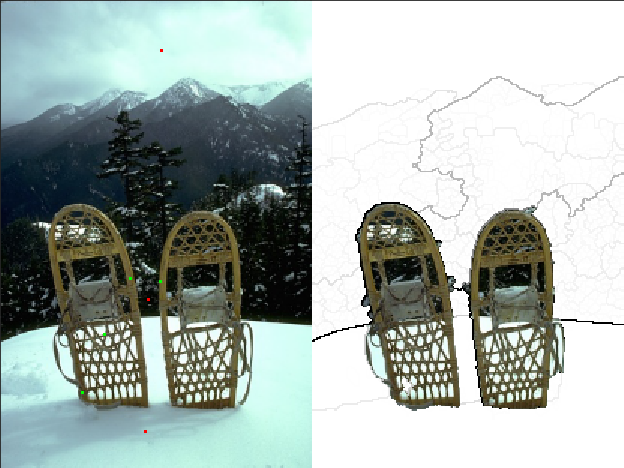

In [10]:
# we will make this figure interactive soon
fig, ax = imshow(base_image)

Once the following block of code will be executed, you will be able to click on the above picture to segment the plane: left click in the area that belongs to the plane and right click on the area outside the plane.

In [11]:
# Define a callback function that will update the drawing
def onclick(event):
    #remove prvious drawing
    ax.clear()
    
    # click position
    x = int(event.xdata) % size[1] # modulo click on the right image wraps on the first one
    y = int(event.ydata)
    
    if event.button == 1: # left click
        markers[y-1:y+1, x-1:x+1, :]= (0,1,0,1) # green marker : object
    elif event.button == 3: # right click
        markers[y-1:y+1, x-1:x+1, :]= (1,0,0,1) # red marker : background
    
    # compute binary segmentation from the two markers
    result = hg.binary_labelisation_from_markers(tree, markers[:,:,1], markers[:,:,0])
    
    # redraw background
    ax.imshow(base_image, interpolation='none')
    
    # use the binary segmentation as the alpha channel to display the result
    tmp = np.copy(image)
    res = np.dstack((tmp,result))
    
    # show markers on left image
    op = np.hstack((markers, res))
    ax.imshow(op, interpolation='none')
    

# Create an hard reference to the callback not to be cleared by the garbage collector
ka = fig.canvas.mpl_connect('button_press_event', onclick)